# Anomaly Detection in Bipartite Graphs - Model Comparison

This notebook compares different models for anomaly detection in bipartite graphs.

In [108]:
# Load the extension
%load_ext autoreload
# Configure it to reload all modules before each cell execution
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom modules
from src.data.dataloader import load_member_features, load_provider_features, load_claims_data, prepare_hetero_data
from src.data.anomaly_injection import  * 
from src.models.main_model import BipartiteGraphAutoEncoder
from src.models.baseline_models import MLPAutoencoder, SklearnBaseline, GCNAutoencoder, GATAutoencoder, SAGEAutoencoder
from src.utils.train_utils import train_model
from src.utils.eval_utils import evaluate_anomaly_detection, plot_precision_recall_curves, plot_anomaly_distribution, compare_models

## 1. Load and Prepare Data

In [110]:
df_member_features, members_dataset = load_member_features("../data/final_members_df.pickle")
df_provider_features, providers_dataset = load_provider_features("../data/final_df.pickle")
df_edges = load_claims_data("../data/df_descriptions.pickle", members_dataset=members_dataset, providers_dataset=providers_dataset)

print(f"Members: {len(members_dataset)}")
print(f"Providers: {len(providers_dataset)}")
print(f"Edges: {len(df_edges)}")

print("\nMember features:")
display(df_member_features.head())
print("\nProvider features:")
display(df_provider_features.head())
print("\nEdges:")
display(df_edges.head())

Members: 32560
Providers: 652
Edges: 58996

Member features:


,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,...,avg_provider_claim_amount,unique_providers,num_claims,prop_claimtype_not_op,prop_claimtype_out-patient,single_interaction_ratio,gender_f,gender_m,principalcode_dependant,principalcode_principal
membercode,,,,,,,,,,,,,,,,,,,,,
589143,-0.304701,-0.212336,-0.315465,-0.051256,-0.674128,0.660569,0.483461,1.201042,0.967073,0.588056,...,0.320333,0.000000,1.906891,0.0,1.0,0.071429,1.0,0.0,0.0,1.0
589150,0.136534,0.267512,0.315465,0.337099,-0.044980,0.693704,0.060593,-0.461668,1.389210,0.919456,...,0.662848,2.089694,2.247928,0.0,1.0,0.111111,1.0,0.0,0.0,1.0
589151,0.000000,0.000000,0.000000,0.000000,0.000000,0.558524,0.686361,-0.390630,0.442232,0.667439,...,0.532630,0.000000,-0.415037,0.0,1.0,1.000000,0.0,1.0,1.0,0.0
589152,-0.665389,-0.362991,0.184535,-0.696713,-1.862060,0.008422,-0.130645,-0.502561,0.214536,0.247757,...,0.330445,0.000000,0.321928,0.0,1.0,0.250000,0.0,1.0,1.0,0.0
589154,1.468108,1.755317,2.210028,1.002648,0.000000,-0.022566,0.373619,0.292756,-0.233386,-0.145385,...,0.035693,0.000000,0.000000,0.0,1.0,0.333333,0.0,1.0,0.0,1.0



Provider features:


,one_hot_claim__finalstatus_infrequent_sklearn,one_hot_claim__claimtype_infrequent_sklearn,one_hot_claim__loastatus_infrequent_sklearn,one_hot_claim__roomtype_infrequent_sklearn,one_hot_claim__principalcode_principal,one_hot_claim__casetype_reimbursement,one_hot_claim__gender_m,one_hot_provider__providertype_clinic,one_hot_provider__providertype_hospital,one_hot_provider__providertype_infrequent_sklearn,...,std_member_claim_amount,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,single_interaction_ratio,num_members,num_claims,hdbscan_cluster_from_semantics
providercode,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.062780,0.008969,0.0,0.349776,0.067265,0.399103,0.0,1.0,0.0,...,0.524022,0.321360,0.050260,-0.262126,0.966920,0.789321,-0.449752,0.563258,0.548708,1
17,0.0,0.000000,0.000000,0.0,0.472222,0.083333,0.333333,1.0,0.0,0.0,...,0.537356,0.474466,0.675916,0.763060,-0.215126,-0.003480,1.110301,-0.277891,-0.568451,1
53,0.0,0.008342,0.005214,0.0,0.662148,0.020855,0.344108,0.0,1.0,0.0,...,-0.393823,-0.617874,-0.583296,-0.231640,0.285726,-0.109757,-0.722677,1.375164,1.451557,1
54,0.0,0.007160,0.004773,0.0,0.625298,0.026253,0.436754,1.0,0.0,0.0,...,-0.328537,-0.548802,-0.583296,-0.440637,0.323048,-0.065129,-0.578037,0.911511,0.938692,1
76,0.0,0.175573,0.000000,0.0,0.694656,0.045802,0.580153,0.0,1.0,0.0,...,0.851399,1.081335,0.571845,0.456543,0.548513,0.721966,0.413834,0.404467,0.220617,1



Edges:


,provider_id,member_id,nbr_claims
3,4,589264,3
4,4,905121,1
6,4,905123,2
7,4,905144,2
8,4,905146,2


In [26]:
# Create HeteroData object
data = prepare_hetero_data(df_member_features, df_provider_features, df_edges)

print(data)
print(f"Member features shape: {data['member'].x.shape}")
print(f"Provider features shape: {data['provider'].x.shape}")
print(f"Number of edges: {data['provider', 'to', 'member'].edge_index.shape[1]}")

HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  },
  (member, to, provider)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  }
)
Member features shape: torch.Size([32560, 23])
Provider features shape: torch.Size([652, 38])
Number of edges: 58996


## 2. Inject Synthetic Anomalies for Evaluation

In [27]:
import torch
import numpy as np
import random
from torch_geometric.data import HeteroData

def inject_combined_anomalies(data: HeteroData, num_injections: int = 20):
    """
    Injects combined topological (structural) and attribute anomalies into the bipartite graph.
    
    For each injection:
      - Randomly selects a subset of nodes from 'provider' and 'member' (size randomized between 2 and 20).
      - Randomly decides whether to create a full dense block anomaly (all pairs connected)
        or a partial dense block anomaly (only a fraction, between 0.2 and 1.0, of possible pairs).
      - For each new edge, a feature anomaly is injected using one of two techniques:
          * "outside": The base edge feature (assumed to be 1.0) is pushed outside a confidence interval by adding a constant c.
          * "scaled": Gaussian noise with zero mean and standard deviation c is added.
        The scaling constant c is randomly chosen between 2 and 4.
      - Optionally, node features of the nodes involved are perturbed with additional Gaussian noise.
      - All nodes and edges involved in each injection are marked as anomalous, and their anomaly types are recorded.
    
    Expected Input:
      data: A PyTorch Geometric HeteroData object with two node types ('provider' and 'member') and an edge type 
            ('provider', 'to', 'member') that includes an 'edge_attr' attribute.
    
    Returns:
      modified_data: The HeteroData object with injected anomalies.
      gt_labels: A dictionary with keys 'provider' and 'member'. Each value is a torch tensor of shape (num_nodes,)
                 with 1 indicating an anomalous node and 0 indicating a normal node.
      anomaly_tracking: A dictionary with keys 'provider' and 'member'. For each node that is anomalous, a set
                        of strings is stored indicating the anomaly type(s) (e.g. 'full_dense', 'partial_dense',
                        'feature_outside', 'feature_scaled', 'feature_node').
    """
    # Clone the data so as not to modify the original
    modified_data = data.clone()
    
    num_providers = modified_data['provider'].num_nodes
    num_members = modified_data['member'].num_nodes
    
    # Initialize ground truth labels and anomaly tracking for nodes
    gt_labels = {
        'provider': torch.zeros(num_providers, dtype=torch.long),
        'member': torch.zeros(num_members, dtype=torch.long)
    }
    anomaly_tracking = {
        'provider': {i: set() for i in range(num_providers)},
        'member': {i: set() for i in range(num_members)}
    }
    
    # Ensure edge attributes exist (assume 1-dimensional, defaulting to 1.0)
    if 'edge_attr' not in modified_data['provider', 'to', 'member'].__dict__:
        num_edges = modified_data['provider', 'to', 'member'].edge_index.size(1)
        modified_data['provider', 'to', 'member'].edge_attr = torch.ones((num_edges, 1))
    
    # Repeat the anomaly injection process num_injections times
    for inj in range(num_injections):
        # Randomize the number of nodes to be involved in this anomaly block (between 2 and 20)
        size_provider = random.randint(2, min(20, num_providers))
        size_member = random.randint(2, min(20, num_members))
        
        # Randomly select nodes from each node type
        providers_anom = np.random.choice(num_providers, size=size_provider, replace=False)
        members_anom = np.random.choice(num_members, size=size_member, replace=False)
        
        # Mark these nodes as anomalous (structure anomaly)
        for p in providers_anom:
            gt_labels['provider'][p] = 1
            anomaly_tracking['provider'][p].add('structural')
        for m in members_anom:
            gt_labels['member'][m] = 1
            anomaly_tracking['member'][m].add('structural')
        
        # Decide between full and partial dense block anomaly (50% chance each)
        full_block = random.random() < 0.5
        if full_block:
            # Create a full dense block: all selected providers connected to all selected members
            new_edges = [(p, m) for p in providers_anom for m in members_anom]
            block_type = 'full_dense'
        else:
            # Create a partial dense block: only a fraction of the possible edges are added
            frac = random.uniform(0.2, 1.0)
            possible_edges = [(p, m) for p in providers_anom for m in members_anom]
            num_edges_to_select = max(1, int(frac * len(possible_edges)))
            new_edges = random.sample(possible_edges, num_edges_to_select)
            block_type = 'partial_dense'
        
        # Retrieve the existing edge set for ('provider', 'to', 'member')
        existing_edge_index = modified_data['provider', 'to', 'member'].edge_index
        existing_edges_set = set([(existing_edge_index[0, i].item(), existing_edge_index[1, i].item())
                                  for i in range(existing_edge_index.size(1))])
        
        # Process each new edge: if it doesn't already exist, add it with an injected feature anomaly
        new_edge_list = []
        new_edge_attr_list = []
        for (p, m) in new_edges:
            if (p, m) in existing_edges_set:
                continue  # Skip if the edge already exists
            # Randomly choose a feature anomaly technique for the edge
            technique = random.choice(['outside', 'scaled'])
            c = random.uniform(2, 4)
            base_val = 1.0  # Assume a default base edge feature
            if technique == 'outside':
                # "Outside" technique: push the value outside the confidence interval
                new_val = base_val + c  # Simplified approximation
                anomaly_type_edge = 'feature_outside'
            else:
                # "Scaled" technique: add Gaussian noise with zero mean and c as standard deviation
                noise = np.random.normal(0, c)
                new_val = base_val + noise
                anomaly_type_edge = 'feature_scaled'
            
            new_edge_list.append((p, m))
            new_edge_attr_list.append([new_val])
            
            # Record the feature anomaly type for both nodes
            anomaly_tracking['provider'][p].add(anomaly_type_edge)
            anomaly_tracking['member'][m].add(anomaly_type_edge)
        
        # Append new edges (and their attributes) to the graph if any were created
        if new_edge_list:
            new_edge_tensor = torch.tensor(new_edge_list, dtype=torch.long).t()
            new_edge_attr_tensor = torch.tensor(new_edge_attr_list, dtype=torch.float)
            modified_data['provider', 'to', 'member'].edge_index = torch.cat(
                [modified_data['provider', 'to', 'member'].edge_index, new_edge_tensor], dim=1
            )
            modified_data['provider', 'to', 'member'].edge_attr = torch.cat(
                [modified_data['provider', 'to', 'member'].edge_attr, new_edge_attr_tensor], dim=0
            )
            # Also update the reverse edges for ('member', 'to', 'provider')
            reverse_new_edges = torch.stack([new_edge_tensor[1], new_edge_tensor[0]], dim=0)
            modified_data['member', 'to', 'provider'].edge_index = torch.cat(
                [modified_data['member', 'to', 'provider'].edge_index, reverse_new_edges], dim=1
            )
            modified_data['member', 'to', 'provider'].edge_attr = torch.cat(
                [modified_data['member', 'to', 'provider'].edge_attr, new_edge_attr_tensor], dim=0
            )
        
        # Optionally, inject node feature anomalies into the nodes involved in this block (50% chance)
        if random.random() < 0.5:
            for node_type, nodes in [('provider', providers_anom), ('member', members_anom)]:
                for idx in nodes:
                    x = modified_data[node_type].x[idx]
                    num_features = x.size(0)
                    # Randomly select approximately 30% of the features to perturb
                    num_to_perturb = max(1, int(0.3 * num_features))
                    perturb_indices = np.random.choice(num_features, num_to_perturb, replace=False)
                    c_node = random.uniform(2, 4)
                    noise = torch.tensor(np.random.normal(0, c_node, size=(num_to_perturb,)), dtype=torch.float)
                    x[perturb_indices] += noise
                    modified_data[node_type].x[idx] = x
                    anomaly_tracking[node_type][idx].add('feature_node')
        
        # Record the type of dense block anomaly injected
        for p in providers_anom:
            anomaly_tracking['provider'][p].add(block_type)
        for m in members_anom:
            anomaly_tracking['member'][m].add(block_type)
    
    # Remove tracking info for nodes that were never marked as anomalous
    anomaly_tracking['provider'] = {i: types for i, types in anomaly_tracking['provider'].items() if gt_labels['provider'][i] == 1}
    anomaly_tracking['member'] = {i: types for i, types in anomaly_tracking['member'].items() if gt_labels['member'][i] == 1}
    
    return modified_data, gt_labels, anomaly_tracking


In [28]:
modified_data, gt_labels, anomaly_tracking = inject_combined_anomalies(data, num_injections=5)

In [93]:
from pyvis.network import Network
import networkx as nx
import random

def simple_visualize_graph(data, gt_labels=None, anomaly_tracking=None, sample_size=50, member_sample_size=5, filename='anomaly_graph.html'):
    """
    Visualize a bipartite graph with anomalies.
    
    This function samples `sample_size` provider nodes randomly, then retrieves up to `member_sample_size`
    members associated with each selected provider.
    
    Args:
        data (HeteroData): The attributed bipartite graph. It must include node feature 'x'
                           for both 'provider' and 'member', and edges of type 
                           ('provider', 'to', 'member') with an optional 'edge_attr'.
        gt_labels (dict): Dictionary with keys 'provider' and 'member', each a torch tensor 
                          of shape [num_nodes] (1 for anomalous, 0 for normal).
        anomaly_tracking (dict): Dictionary with keys 'provider' and 'member'. For each anomalous
                                 node (by index), a set of strings indicates the injected anomaly types.
        sample_size (int): Number of provider nodes to sample.
        member_sample_size (int): Number of members to sample per selected provider.
        filename (str): Name of the output HTML file for the visualization.
    
    Returns:
        net (pyvis.network.Network): A pyvis interactive network.
    """
    num_providers = data['provider'].num_nodes
    edge_index = data['provider', 'to', 'member'].edge_index
    edge_attr = getattr(data['provider', 'to', 'member'], 'edge_attr', None)
    
    provider_indices = random.sample(range(num_providers), min(sample_size, num_providers))
    member_indices = set()
    
    # Retrieve associated members for selected providers
    for idx in range(edge_index.size(1)):
        p = edge_index[0, idx].item()
        m = edge_index[1, idx].item()
        if p in provider_indices:
            member_indices.add(m)
    
    # Limit the number of members per provider
    member_indices = list(member_indices)
    random.shuffle(member_indices)
    member_indices = member_indices[:sample_size * member_sample_size]
    
    # Create a NetworkX graph
    G = nx.Graph()
    node_colors = {}  # Store colors explicitly
    
    # Add provider nodes with colors and labels based on anomaly status
    for i in provider_indices:
        node_id = f"provider_{i}"
        if gt_labels is not None and gt_labels['provider'][i] == 1:
            color = "red"
            extra = f"\nAnomalies: {', '.join(anomaly_tracking['provider'].get(i, []))}"
        else:
            color = "blue"
            extra = ""
        title = f"Provider {i}{extra}"
        G.add_node(node_id, label=f"P{i}", title=title, group='provider')
        node_colors[node_id] = color  # Explicitly track color
    
    # Add member nodes similarly
    for i in member_indices:
        node_id = f"member_{i}"
        if gt_labels is not None and gt_labels['member'][i] == 1:
            color = "orange"
            extra = f"\nAnomalies: {', '.join(anomaly_tracking['member'].get(i, []))}"
        else:
            color = "green"
            extra = ""
        title = f"Member {i}{extra}"
        G.add_node(node_id, label=f"M{i}", title=title, group='member')
        node_colors[node_id] = color  # Explicitly track color
    
    # Add edges (only if both endpoints are in our sample)
    for idx in range(edge_index.size(1)):
        p = edge_index[0, idx].item()
        m = edge_index[1, idx].item()
        if p in provider_indices and m in member_indices:
            provider_id = f"provider_{p}"
            member_id = f"member_{m}"
            title = f"Edge weight: {edge_attr[idx].item()}" if edge_attr is not None else ""
            G.add_edge(provider_id, member_id, title=title)
    
    # Create and configure a pyvis Network
    net = Network(height="600px", width="100%", notebook=True)
    net.from_nx(G)
    
    # Explicitly set colors in Pyvis
    for node in net.nodes:
        node['color'] = node_colors[node['id']]
    
    net.save_graph(filename)
    
    return net


In [39]:
gt_labels["provider"][564]
anomaly_tracking["provider"][564]

{'feature_node',
 'feature_outside',
 'feature_scaled',
 'partial_dense',
 'structural'}

In [94]:
net = simple_visualize_graph(modified_data, gt_labels, anomaly_tracking, sample_size=1000, filename='anomaly_graph.html')

In [95]:
np.random.seed(42)
torch.manual_seed(42)

# Inject anomalies
anomaly_percentage = 0.05  # 5% of nodes will be anomalies
anomaly_data, member_anomaly_labels, original_member_x = inject_anomalies(
    data, 'member', percentage=anomaly_percentage, scale=5.0
)

anomaly_data, provider_anomaly_labels, original_provider_x = inject_anomalies(
    anomaly_data, 'provider', percentage=anomaly_percentage, scale=5.0
)

print(f"Injected {member_anomaly_labels.sum().item()} member anomalies")
print(f"Injected {provider_anomaly_labels.sum().item()} provider anomalies")

Injected 1628 member anomalies
Injected 32 provider anomalies


## 3. Define Models to Compare

In [104]:
# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move data to device
modified_data = modified_data.to(device)
member_anomaly_labels = gt_labels["member"].to(device)
provider_anomaly_labels = gt_labels["provider"].to(device)

# Set dimensions based on data
in_dim_member = modified_data['member'].x.size(1)
in_dim_provider = modified_data['provider'].x.size(1)
max_dim = max(in_dim_member, in_dim_provider)
hidden_dim = 64
latent_dim = 32
edge_dim = 1  # For 'nbr_claims' as a scalar

# Define models to compare
models = {
    'MLP_Autoencoder': MLPAutoencoder(in_dim_member, in_dim_provider, hidden_dim, latent_dim).to(device),
    'Isolation_Forest': SklearnBaseline(method='iforest', n_estimators=100),
    'PCA': SklearnBaseline(method='pca', n_components=0.9),
    'GCN_Autoencoder': GCNAutoencoder(max_dim, hidden_dim, latent_dim).to(device),
    #'GAT_Autoencoder': GATAutoencoder(in_dim_member, in_dim_provider, hidden_dim, latent_dim).to(device),
    #'SAGE_Autoencoder': SAGEAutoencoder(max_dim, hidden_dim, latent_dim).to(device),
    'Bipartite_GAE': BipartiteGraphAutoEncoder(
        in_dim_member=in_dim_member,
        in_dim_provider=in_dim_provider,
        edge_dim=edge_dim,
        hidden_dim_member=hidden_dim,
        hidden_dim_provider=hidden_dim,
        out_dim=latent_dim,
        num_layers=2
    ).to(device)
}

Using device: mps


In [14]:
# Get feature dimensions from the data
in_dim_member = anomaly_data['member'].x.size(1)
in_dim_provider = anomaly_data['provider'].x.size(1)

# Initialize model with correct dimensions
model = GATAutoencoder(
    in_dim_member=in_dim_member,
    in_dim_provider=in_dim_provider,
    hidden_dim=64,
    latent_dim=32,
    heads=4,
    dropout=0.5
).to(device)

## 4. Train and Evaluate Models


--------------------------------------------------
Training and evaluating MLP_Autoencoder...
Epoch 001 | Train Loss: 1.8531 | Val Loss: 1.7990


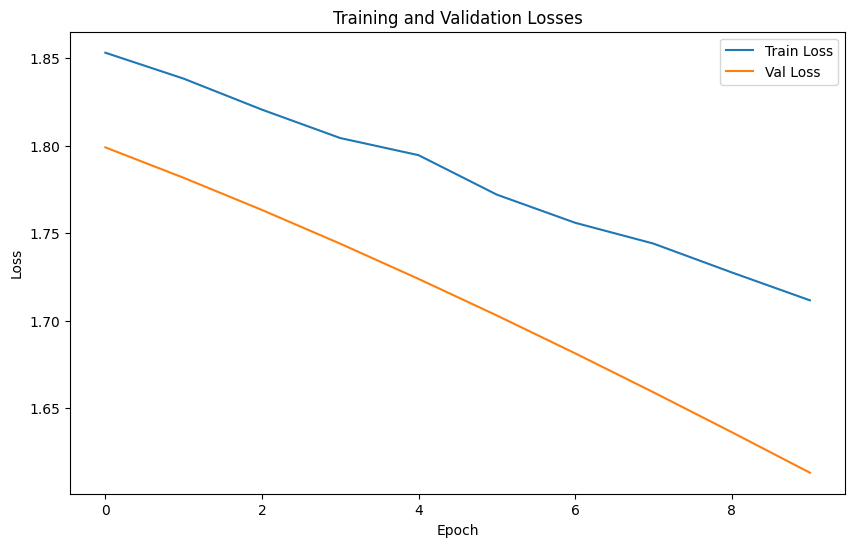


Results for MLP_Autoencoder:
  Member: AUC = 0.7224, AP = 0.1330
  Provider: AUC = 0.7669, AP = 0.5368

--------------------------------------------------
Training and evaluating Isolation_Forest...

Results for Isolation_Forest:
  Member: AUC = 0.6480, AP = 0.0042
  Provider: AUC = 0.7794, AP = 0.4825

--------------------------------------------------
Training and evaluating PCA...

Results for PCA:
  Member: AUC = 0.7508, AP = 0.3956
  Provider: AUC = 0.7945, AP = 0.6354

--------------------------------------------------
Training and evaluating GCN_Autoencoder...
Epoch 001 | Train Loss: 1.9768 | Val Loss: 1.8000


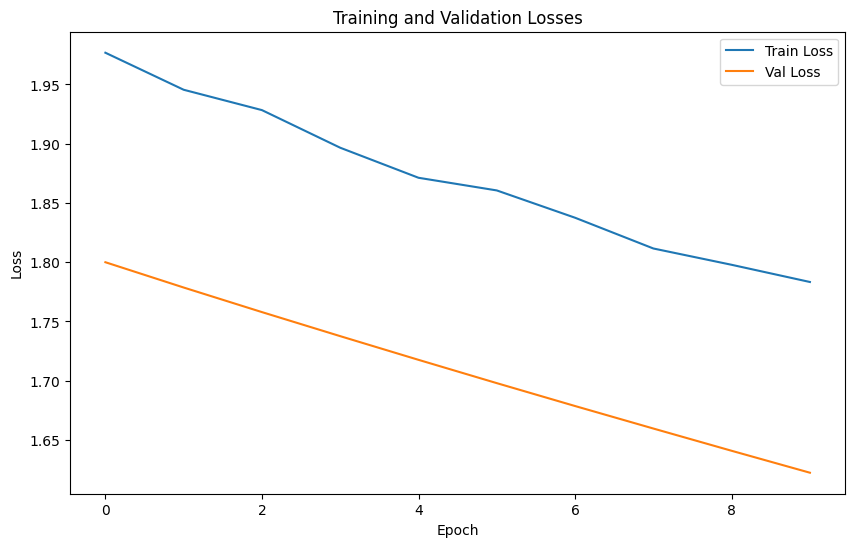


Results for GCN_Autoencoder:
  Member: AUC = 0.7212, AP = 0.1563
  Provider: AUC = 0.7603, AP = 0.5560

--------------------------------------------------
Training and evaluating Bipartite_GAE...
Epoch 001 | Train Loss: 1.8698 | Val Loss: 1.7900


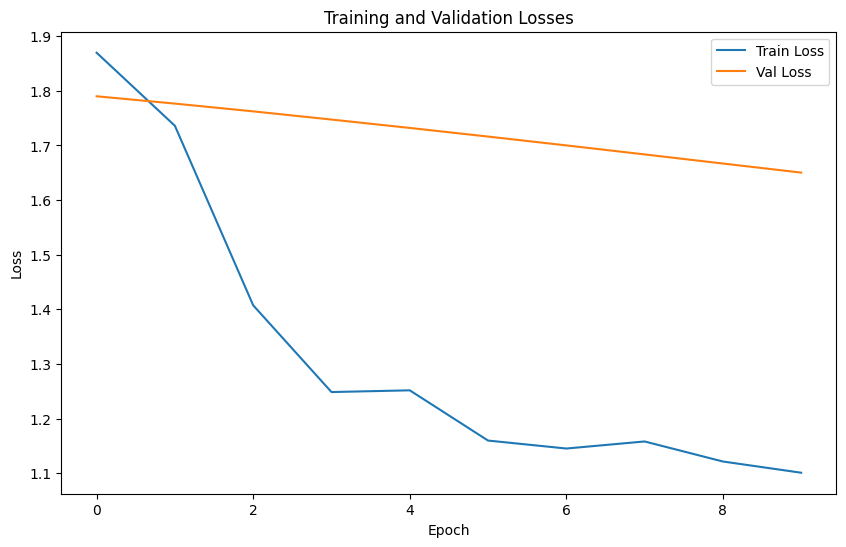


Results for Bipartite_GAE:
  Member: AUC = 0.7221, AP = 0.1641
  Provider: AUC = 0.7633, AP = 0.5087


In [111]:
all_results = {}
gt_labels = {
    'member': member_anomaly_labels,
    'provider': provider_anomaly_labels
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'-'*50}\nTraining and evaluating {name}...")
    
    if hasattr(model, 'fit'):  # For sklearn-based models
        model.fit(modified_data)
        results = evaluate_anomaly_detection(model, modified_data, gt_labels)
    else:  # For PyTorch models
        train_model(model, modified_data, num_epochs=10, plot=True)
        results = evaluate_anomaly_detection(model, modified_data, gt_labels)
    
    all_results[name] = results
    
    # Print quick summary
    print(f"\nResults for {name}:")
    for node_type in results:
        print(f"  {node_type.capitalize()}: AUC = {results[node_type]['auc']:.4f}, AP = {results[node_type]['ap']:.4f}")

## 5. Compare Results

In [12]:
# Compare all models in a table
comparison_df = compare_models(all_results, list(models.keys()))
display(comparison_df)

,Model,Member AUC,Member AP,Provider AUC,Provider AP,Avg AUC,Avg AP
1,Isolation_Forest,0.999997,0.999937,0.999899,0.998076,0.999948,0.999007
3,GCN_Autoencoder,0.999989,0.999779,0.999748,0.995427,0.999868,0.997603
0,MLP_Autoencoder,0.999977,0.999557,0.999546,0.991948,0.999762,0.995753
4,Bipartite_GAE,0.999983,0.999661,0.999446,0.990429,0.999714,0.995045
2,PCA,0.998126,0.987697,0.990222,0.810734,0.994174,0.899215


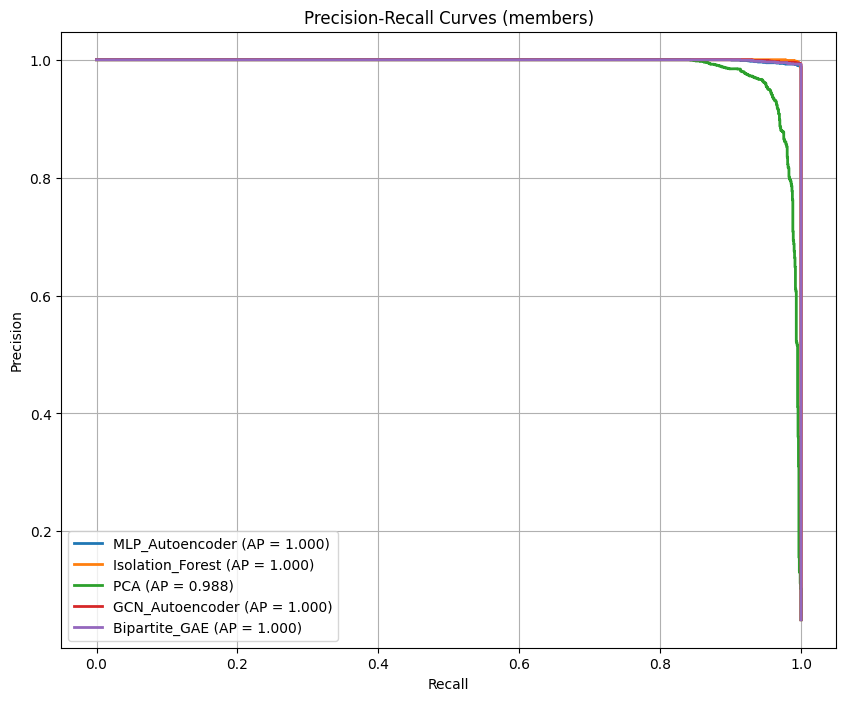

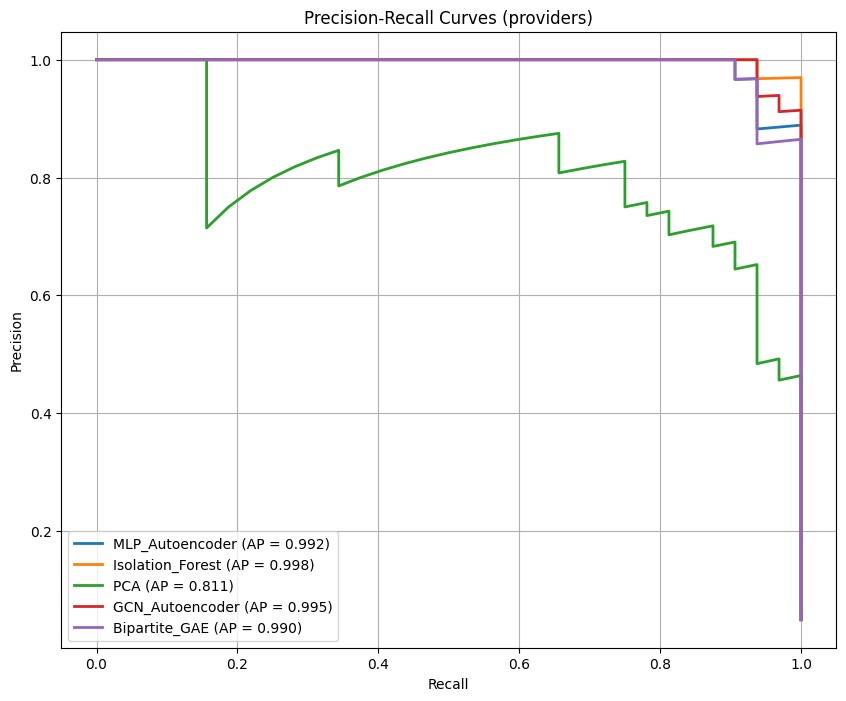

In [13]:
# Plot precision-recall curves for members
plot_precision_recall_curves(all_results, list(models.keys()), node_type='member')

# Plot precision-recall curves for providers
plot_precision_recall_curves(all_results, list(models.keys()), node_type='provider')

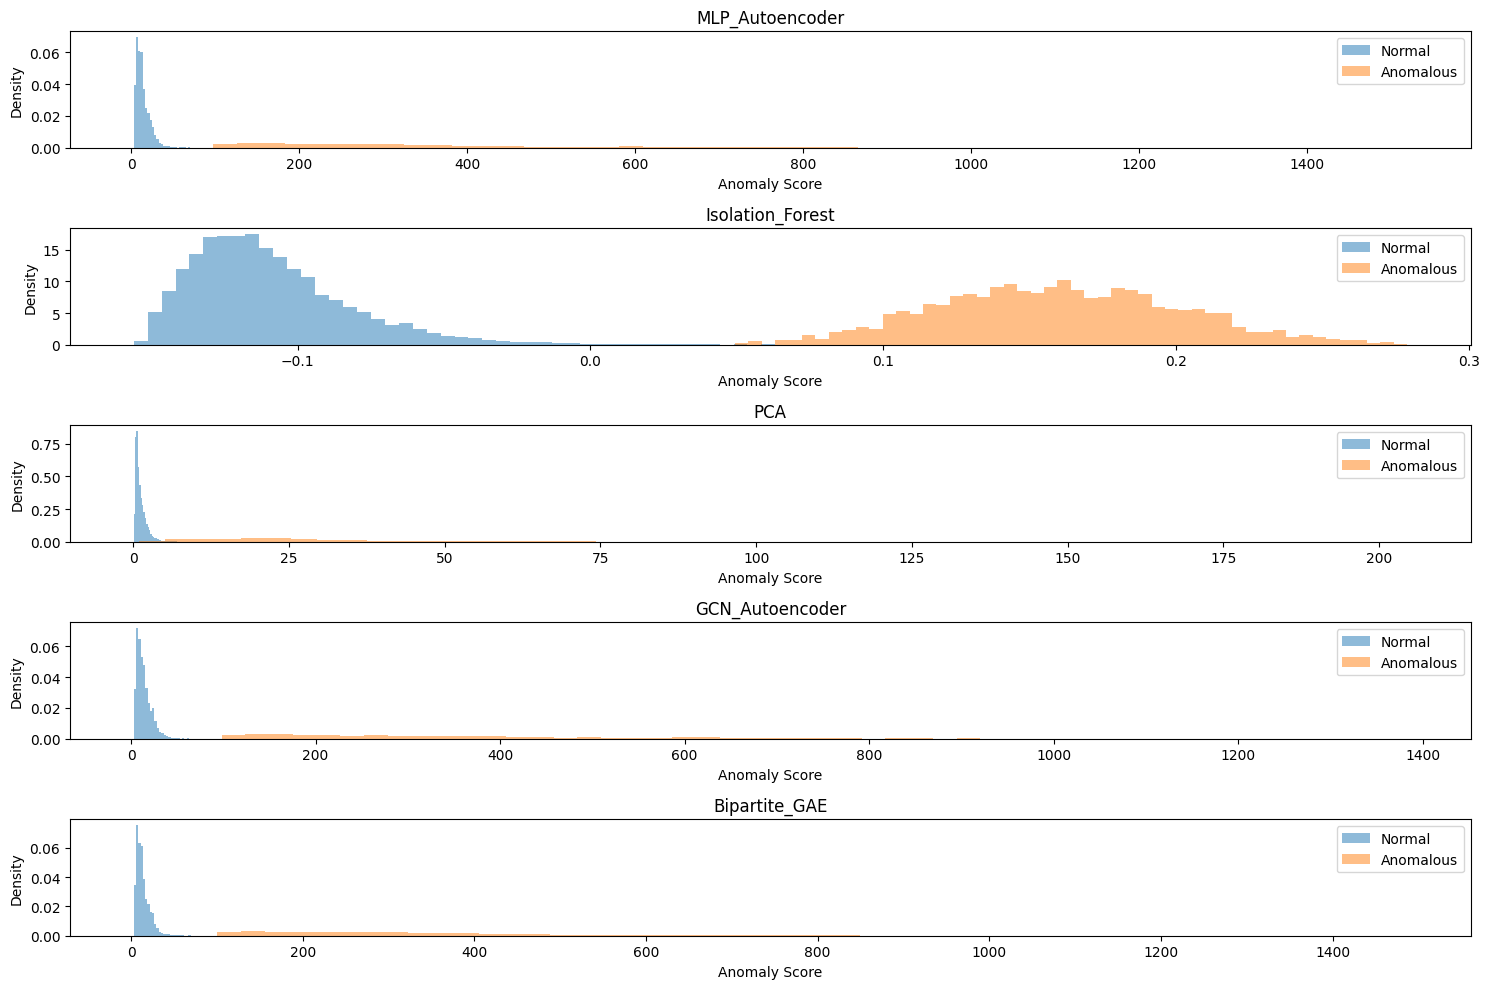

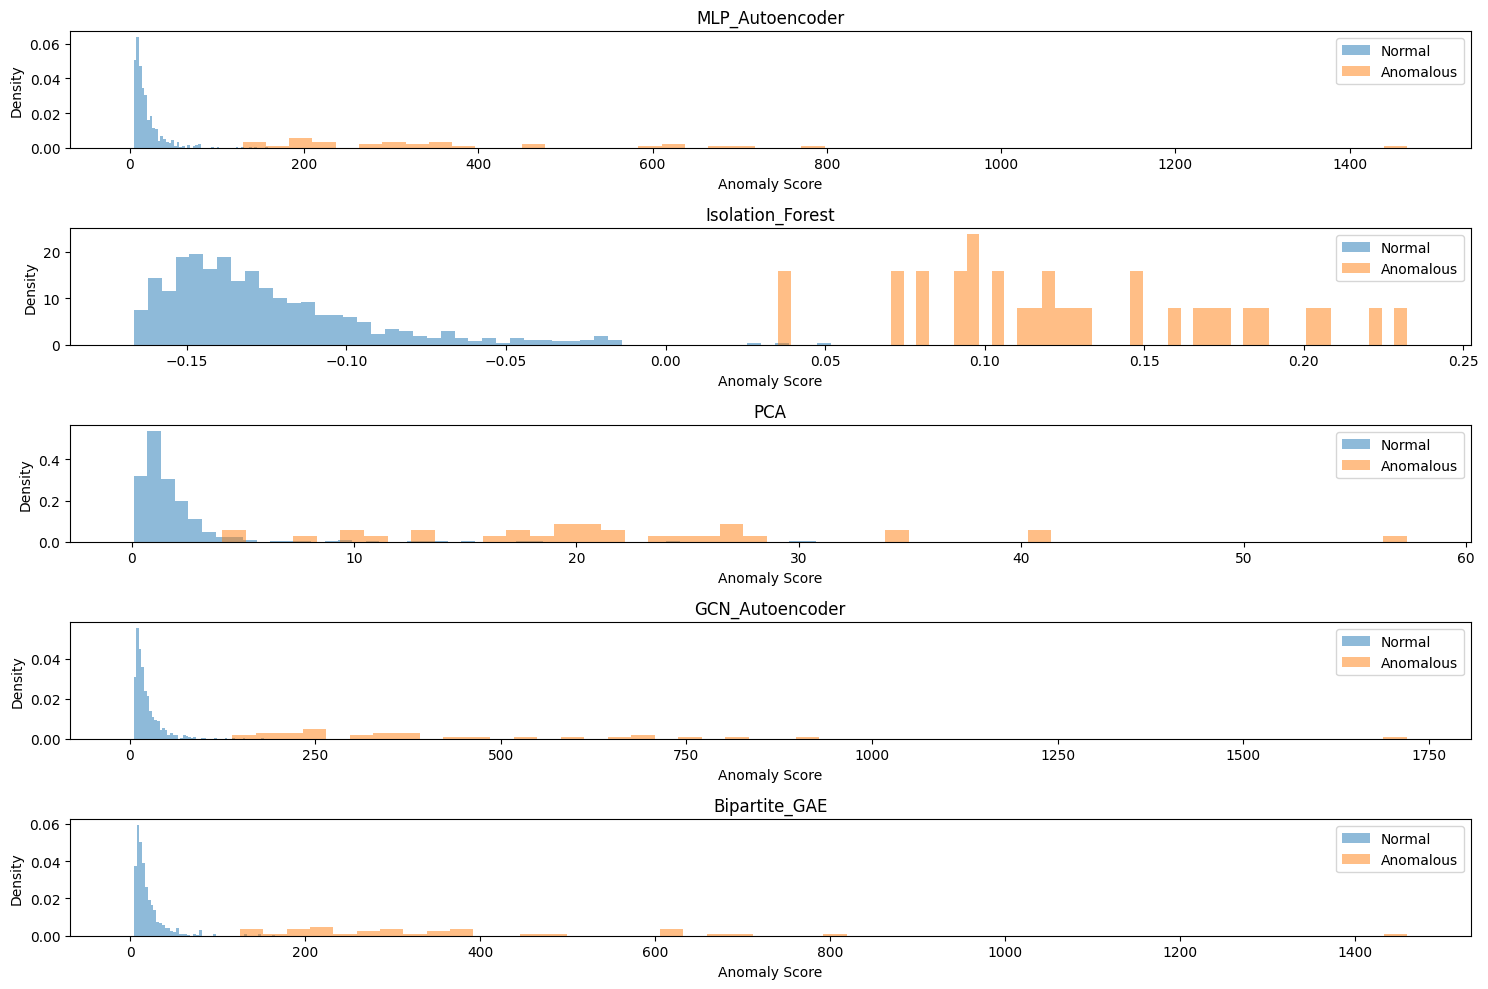

In [14]:
# Plot anomaly score distributions
plot_anomaly_distribution(all_results, list(models.keys()), node_type='member')
plot_anomaly_distribution(all_results, list(models.keys()), node_type='provider')

## 6. Analysis and Conclusion

Based on the results above, we can draw the following conclusions:

1. **Performance Comparison**: [Your analysis based on the results]
2. **Strengths and Weaknesses**: [Discuss strengths/weaknesses of different models]
3. **Recommended Model**: [Which model performed best and why]
4. **Future Work**: [Suggestions for improvements]